In [1]:
import numpy as np
from tqdm import tqdm
from DecisionTrees import *


class RegressionBoostingTree(object):
    def __init__(self, max_depth=float("inf"), min_samples_split=2, max_estimators=float("inf"), 
                tol=1e-9):
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.max_estimators=max_estimators
        self.tol = tol
        self.trees = []
    
    def fit(self, X, y):
        if len(X.shape)==1:
            X = np.expand_dims(X, axis=1)
        m,n = X.shape
        tree_i = 0
        tol = float("inf")
        while tol>self.tol and tree_i<self.max_estimators:
            tree = RegressionTree(max_depth=self.max_depth, 
                                  min_samples_split=self.min_samples_split)
            tree.fit(X,y)
            y_pred=tree.predict(X)
            rm = y-y_pred
            tol = rm.dot(rm)
            y = rm
            tree_i += 1
            self.trees.append(tree)
        print("square loss is %f, trees number is %d" % (tol, tree_i))          
            
    
    def predict(self, X):
        if len(X.shape)==1:
            X = np.expand_dims(X, axis=1)
        y = np.zeros(X.shape[0])
        for tree in self.trees:
            y += np.array(tree.predict(X))
        return y

In [2]:
import numpy as np
from tqdm import tqdm
from DecisionTrees import *

class Loss(object):
    def __init__(self): pass
    def loss(self, y, y_pred): return NotImplementedError()
    def gradient(self, y, y_pred): return NotImplementedError()
        
class SquareError(Loss):
    def loss(self, y, y_pred):
        return .5*(y-y_pred).dot(y-y_pred)
    
    def gradient(self, y, y_pred):
        return -(y-y_pred)

    
class CrossEntropy(Loss):
    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
        return -y*np.log(y_pred) - (1-y)*np.log(1-y_pred)
    
    def gradient(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
        return -y/y_pred + (1-y)/(1-y_pred)
    
    
class Softmax(Loss):
    def loss(self, y, y_pred):
        return y*np.log1p(np.exp(-y_pred)) + (1-y)*np.log1p(np.exp(y_pred))
    
    def gradient(self, y, y_pred):
        return -y + 1/(1+np.exp(-y_pred))


class GradientBoostingDecisionTree(object):
    def __init__(self, max_depth=float("inf"), min_samples_split=2, n_estimators=1, 
                learning_rate=1, loss=None):
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_estimators=n_estimators
        self.learning_rate=learning_rate
        self.base_estimator=RegressionTree
        self.loss=loss()
        self.trees=[]
        for i in range(self.n_estimators):
            self.trees.append(self.base_estimator(max_depth, min_samples_split))
    
    def fit(self, X, y):
        self.trees[0].fit(X,y)
        y_pred = self.trees[0].predict(X)
        for i in tqdm(range(1,self.n_estimators)):
            rm = -self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, rm)
            y_pred += self.learning_rate * self.trees[i].predict(X)
    
    def predict(self, X):
        y_pred = self.trees[0].predict(X)
        for i in range(1, self.n_estimators):
            y_pred += self.learning_rate * self.trees[i].predict(X)
        return y_pred
    
class GBClassificationTree(GradientBoostingDecisionTree):
    def __init__(self, max_depth=float("inf"), min_samples_split=2, n_estimators=1, 
                learning_rate=1):
        super(GBClassificationTree, self).__init__(max_depth=max_depth, min_samples_split=min_samples_split,
                                         n_estimators=n_estimators, learning_rate=learning_rate,
                                         loss=Softmax)    

class GBRegressionTree(GradientBoostingDecisionTree):
    def __init__(self, max_depth=float("inf"), min_samples_split=2, n_estimators=1, 
                learning_rate=1):
        super(GBRegressionTree, self).__init__(max_depth=max_depth, min_samples_split=min_samples_split,
                                         n_estimators=n_estimators, learning_rate=learning_rate,
                                           loss=SquareError)
        

    

100%|██████████| 5/5 [00:00<00:00, 813.29it/s]


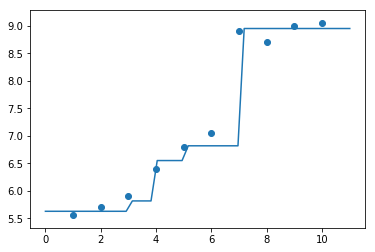

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 
x = np.arange(10)+1
x = x.reshape([-1,1])
y = np.array([5.56,5.7,5.91,6.4,6.8,7.05,8.9,8.7,9,9.05])

clf = GBRegressionTree(max_depth=1, n_estimators=6)
clf.fit(x,y)

X = np.linspace(0,11,50).reshape([-1,1])
y_pred = clf.predict(X)

plt.figure()
plt.plot(X.squeeze(), y_pred, '-')
plt.scatter(x,y)
plt.show()

100%|██████████| 49/49 [01:05<00:00,  1.33s/it]


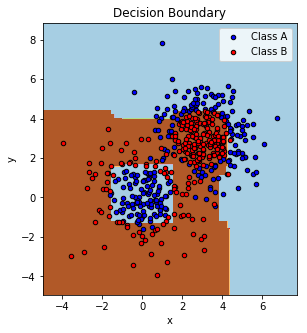

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

plt.figure(figsize=(10,20))
# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

#Create and fit an AdaBoosted decision tree
#bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
#                         algorithm="SAMME",
#                         n_estimators=200)

#bdt = AdaBoost(ClassificationTree(max_depth=1), n_estimators=200)
bdt = GBClassificationTree(max_depth=1, n_estimators=50)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

#plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.sign(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

plt.show()

100%|██████████| 99/99 [02:13<00:00,  1.35s/it]


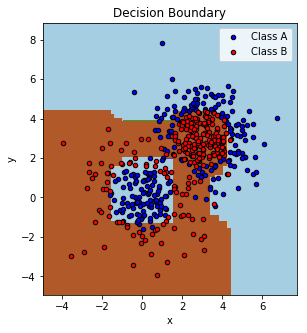

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))




plt.figure(figsize=(10,5))
plt.subplot(121)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

bdt = GBClassificationTree(max_depth=1, n_estimators=100)
bdt.fit(X, y)

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.sign(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

plt.show()